In [8]:
#required imports
import pandas as pd
df = pd.read_csv("Covid_Data.csv", low_memory=False)

# **Step1: Data Pre-processing**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Columns: 512 entries, RecordNo to future_3
dtypes: float64(1), int64(3), object(508)
memory usage: 25.1+ MB


In [10]:
#check for duplicates
df.duplicated().sum()

0

In [11]:
#Percentage of missing values (nan or ' ')
missing_percentage = ((df.isnull() | (df == ' ') | (df == '__NA__')).mean()) * 100

#filter everything >50% blank
to_drop = list(missing_percentage[missing_percentage > 50].index)

#remove columns with unclear metadata: future_1, future_2, qweek
#remove RecordNo and end time, not needed for analysis
to_drop.extend(['future_1', 'future_2','qweek','RecordNo','endtime'])

#drop these columns
df_cleaned1 = df.drop(columns=to_drop)
df_cleaned1.head()

,i2_health,i9_health,i11_health,i12_health_1,i12_health_2,i12_health_3,i12_health_4,i12_health_5,i12_health_6,i12_health_7,...,vac_man_1,vac_man_2,vac_man_3,vac_man_4,vac_man_5,vac_man_6,vac_man_7,vac_man_96,vac_man_99,had_covid_2
0,0,Yes,Very willing,Always,Always,Always,Always,Always,Frequently,Always,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,NaN
1,1,No,Very willing,Always,Always,Always,Always,Always,Always,Always,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,NaN
2,0,No,Very willing,Always,Always,Always,Always,Frequently,Sometimes,Frequently,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,NaN
3,5,Yes,Very willing,Always,Always,Always,Always,Always,Always,Always,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,NaN
4,150,Yes,Very willing,Always,Always,Always,Always,Always,Sometimes,Always,...,Yes,Yes,Yes,Yes,Yes,No,No,No,No,NaN


In [12]:
# Filter columns that start with 'd1_health'
filtered_df = df.filter(like='d1_health')

# Display the filtered DataFrame with only columns starting with 'd1_health'
filtered_df[filtered_df["d1_health_1"]==' ']

,d1_health_1,d1_health_2,d1_health_3,d1_health_4,d1_health_5,d1_health_6,d1_health_7,d1_health_8,d1_health_9,d1_health_10,d1_health_11,d1_health_12,d1_health_13,d1_health_98,d1_health_99
0,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
12,,,,,,,,,,,,,,,
14,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6425,,,,,,,,,,,,,,,
6426,,,,,,,,,,,,,,,
6427,,,,,,,,,,,,,,,
6428,,,,,,,,,,,,,,,


In [13]:
#row 4423-6430, seems to be a pattern of missing data, drop it
df_cleaned1[df_cleaned1["i2_health"]==' ']["i2_health"]

,i2_health
4423,
4424,
4425,
4426,
4427,
...,...
6425,
6426,
6427,
6428,


In [14]:
#after investigation, 3028 did not respond to any d1_health
#an assumption could be made for these 3028, they do not have any pre-existing health conditons
#but d1_health_99 asks none of these: blank too. These respondents may not have received this form
#drop these columns, they are not reliable for analysis

col_to_drop = list(filtered_df.columns)
#add i2_health to the drop list
#also drop had_covid_2; there's ' ' and NaN; hard to replace for a binary variable
col_to_drop.extend(['i2_health','had_covid_2'])
df_cleaned2 = df_cleaned1.drop(columns=col_to_drop)
df_cleaned2.head()

,i9_health,i11_health,i12_health_1,i12_health_2,i12_health_3,i12_health_4,i12_health_5,i12_health_6,i12_health_7,i12_health_8,...,vac_boost_1,vac_man_1,vac_man_2,vac_man_3,vac_man_4,vac_man_5,vac_man_6,vac_man_7,vac_man_96,vac_man_99
0,Yes,Very willing,Always,Always,Always,Always,Always,Frequently,Always,Always,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No
1,No,Very willing,Always,Always,Always,Always,Always,Always,Always,Always,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No
2,No,Very willing,Always,Always,Always,Always,Frequently,Sometimes,Frequently,Rarely,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No
3,Yes,Very willing,Always,Always,Always,Always,Always,Always,Always,Always,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No
4,Yes,Very willing,Always,Always,Always,Always,Always,Sometimes,Always,Sometimes,...,No,Yes,Yes,Yes,Yes,Yes,No,No,No,No


In [15]:
#blank or not sure, assume no. Follows covid research eg if you aren't sure if you will isolate, you will not
#https://www.healthline.com/health-news/when-is-it-safe-to-be-around-someone-whos-recovered-from-covid-19-2

bool_map={
    "Yes":1,
    "No":0,
    "Not sure":0,
    " ":0
}
willing_map = {
    'Very willing':1,
    'Somewhat willing':2,
    'Neither willing nor unwilling':3,
    'Somewhat unwilling':4,
    'Very unwilling':5,
    'Not sure':3
}

#following mode imputation
health_map = {
    'Always':1,
    'Frequently':2,
    'Sometimes':3,
    'Rarely':4,
    'Not at all':5,
    ' ':1
}

#following mode imputation
houseSize_map={
    'Prefer not to say' : 2,
    '8 or more': 8,
    "Don't know":2

}

#following mode imputation
houseChild_map={
    'Prefer not to say' : 0,
    '5 or more': 5,
    "Don't know":0

}

#following mode imputation
phq4_map = {
    'Not at all':1,
    'Several days':2,
    'More than half the days':3,
    'Nearly every day':4,
    'Prefer not to say':1
}

seven_scale_map={
    '1 – Disagree':1,
    '7 - Agree':7
}

five_scale_map={
    '5 – Strongly disagree':5,
    '1 - Strongly agree':1
}

four_scale_map={
    'Not at all':1,
    'A little':2,
    'Moderately':3,
    'Very much':4
}

vaccine_map={
    'Yes, two doses':2,
    'Yes, one dose':1,
    'No, neither':0
}

gender_map={
    'Female':1,
    'Male':0
}
#mode imputation
handle_map={
    'Very well':1,
    'Somewhat well':2,
    'Somewhat badly':3,
    'Very badly':4,
    "Don't know":2
}
#mode imputation
confidence_map={
    'A lot of confidence':1,
    'A fair amount of confidence':2,
    'Not very much confidence':3,
    'No confidence at all':4,
    "Don't know":2
}

In [16]:
#working with 61 columns

df_cleaned2['i9_health'] = df_cleaned2['i9_health'].map(bool_map)

df_cleaned2['i11_health'] = df_cleaned2['i11_health'].map(willing_map)

df_cleaned2['i12_health_1'] = df_cleaned2['i12_health_1'].map(health_map)
df_cleaned2['i12_health_2'] = df_cleaned2['i12_health_2'].map(health_map)
df_cleaned2['i12_health_3'] = df_cleaned2['i12_health_3'].map(health_map)
df_cleaned2['i12_health_4'] = df_cleaned2['i12_health_4'].map(health_map)
df_cleaned2['i12_health_5'] = df_cleaned2['i12_health_5'].map(health_map)
df_cleaned2['i12_health_6'] = df_cleaned2['i12_health_6'].map(health_map)
df_cleaned2['i12_health_7'] = df_cleaned2['i12_health_7'].map(health_map)
df_cleaned2['i12_health_8'] = df_cleaned2['i12_health_8'].map(health_map)
df_cleaned2['i12_health_11'] = df_cleaned2['i12_health_11'].map(health_map)
df_cleaned2['i12_health_12'] = df_cleaned2['i12_health_12'].map(health_map)
df_cleaned2['i12_health_13'] = df_cleaned2['i12_health_13'].map(health_map)
df_cleaned2['i12_health_14'] = df_cleaned2['i12_health_14'].map(health_map)
df_cleaned2['i12_health_15'] = df_cleaned2['i12_health_15'].map(health_map)
df_cleaned2['i12_health_16'] = df_cleaned2['i12_health_16'].map(health_map)
df_cleaned2['i12_health_22'] = df_cleaned2['i12_health_22'].map(health_map)
df_cleaned2['i12_health_23'] = df_cleaned2['i12_health_23'].map(health_map)
df_cleaned2['i12_health_25'] = df_cleaned2['i12_health_25'].map(health_map)
df_cleaned2['i12_health_26'] = df_cleaned2['i12_health_26'].map(health_map)
df_cleaned2['i12_health_27'] = df_cleaned2['i12_health_27'].map(health_map)
df_cleaned2['i12_health_28'] = df_cleaned2['i12_health_28'].map(health_map)
df_cleaned2['i12_health_29'] = df_cleaned2['i12_health_29'].map(health_map)


df_cleaned2['gender'] = df_cleaned2['gender'].map(gender_map)

df_cleaned2['household_size'] = df_cleaned2['household_size'].replace(houseSize_map)
df_cleaned2['household_children'] = df_cleaned2['household_children'].replace(houseChild_map)

df_cleaned2['household_size'] = df_cleaned2['household_size'].astype(int)
df_cleaned2['household_children'] = df_cleaned2['household_children'].astype(int)

df_cleaned2['PHQ4_1'] = df_cleaned2['PHQ4_1'].map(phq4_map)
df_cleaned2['PHQ4_2'] = df_cleaned2['PHQ4_2'].map(phq4_map)
df_cleaned2['PHQ4_3'] = df_cleaned2['PHQ4_3'].map(phq4_map)
df_cleaned2['PHQ4_4'] = df_cleaned2['PHQ4_4'].map(phq4_map)

df_cleaned2['r1_1'] = df_cleaned2['r1_1'].replace(seven_scale_map)
df_cleaned2['r1_2'] = df_cleaned2['r1_2'].replace(seven_scale_map)
df_cleaned2['r1_8'] = df_cleaned2['r1_8'].replace(seven_scale_map)
df_cleaned2['r1_9'] = df_cleaned2['r1_9'].replace(seven_scale_map)

df_cleaned2['r1_1'] = df_cleaned2['r1_1'].astype(int)
df_cleaned2['r1_2'] = df_cleaned2['r1_2'].astype(int)
df_cleaned2['r1_8'] = df_cleaned2['r1_8'].astype(int)
df_cleaned2['r1_9'] = df_cleaned2['r1_9'].astype(int)

df_cleaned2['Soc1_1'] = df_cleaned2['Soc1_1'].map(bool_map)
df_cleaned2['Soc1_2'] = df_cleaned2['Soc1_2'].map(bool_map)
df_cleaned2['Soc1_3'] = df_cleaned2['Soc1_3'].map(bool_map)

df_cleaned2['vac2_1'] = df_cleaned2['vac2_1'].replace(five_scale_map)
df_cleaned2['vac2_2'] = df_cleaned2['vac2_2'].replace(five_scale_map)
df_cleaned2['vac2_3'] = df_cleaned2['vac2_3'].replace(five_scale_map)
df_cleaned2['vac2_7'] = df_cleaned2['vac2_7'].replace(five_scale_map)

df_cleaned2['vac2_1'] = df_cleaned2['vac2_1'].astype(int)
df_cleaned2['vac2_2'] = df_cleaned2['vac2_2'].astype(int)
df_cleaned2['vac2_3'] = df_cleaned2['vac2_3'].astype(int)
df_cleaned2['vac2_7'] = df_cleaned2['vac2_7'].astype(int)

df_cleaned2['vac_boost_1'] = df_cleaned2['vac_boost_1'].map(bool_map)
df_cleaned2['vac_man_1'] = df_cleaned2['vac_man_1'].map(bool_map)
df_cleaned2['vac_man_2'] = df_cleaned2['vac_man_2'].map(bool_map)
df_cleaned2['vac_man_3'] = df_cleaned2['vac_man_3'].map(bool_map)
df_cleaned2['vac_man_4'] = df_cleaned2['vac_man_4'].map(bool_map)
df_cleaned2['vac_man_5'] = df_cleaned2['vac_man_5'].map(bool_map)
df_cleaned2['vac_man_6'] = df_cleaned2['vac_man_6'].map(bool_map)
df_cleaned2['vac_man_7'] = df_cleaned2['vac_man_7'].map(bool_map)
df_cleaned2['vac_man_96'] = df_cleaned2['vac_man_96'].map(bool_map)
df_cleaned2['vac_man_99'] = df_cleaned2['vac_man_99'].map(bool_map)

df_cleaned2['vac'] = df_cleaned2['vac'].map(vaccine_map)

df_cleaned2['Vent_3'] = df_cleaned2['Vent_3'].map(health_map)

df_cleaned2['vac7'] = df_cleaned2['vac7'].map(four_scale_map)

df_cleaned2['WCRex2'] = df_cleaned2['WCRex2'].map(confidence_map)
df_cleaned2['WCRex1'] = df_cleaned2['WCRex1'].map(handle_map)

In [17]:
df_cleaned2.head()

,i9_health,i11_health,i12_health_1,i12_health_2,i12_health_3,i12_health_4,i12_health_5,i12_health_6,i12_health_7,i12_health_8,...,vac_boost_1,vac_man_1,vac_man_2,vac_man_3,vac_man_4,vac_man_5,vac_man_6,vac_man_7,vac_man_96,vac_man_99
0,1,1,1,1,1,1,1,2,1,1,...,1,1,1,1,1,1,1,1,0,0
1,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,0
2,0,1,1,1,1,1,2,3,2,4,...,1,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,0
4,1,1,1,1,1,1,1,3,1,3,...,0,1,1,1,1,1,0,0,0,0


# **Step2: Exploratory Data Analysis**

In [19]:
covid = df_cleaned2

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

#### ***Explore the target variable***

In [21]:
covid['vac_boost_1'].value_counts()

,count
vac_boost_1,
1,3646
0,2784


In [22]:
covid['vac_boost_1'].value_counts(normalize=True) * 100

,proportion
vac_boost_1,
1,56.702955
0,43.297045


In [23]:
# helper function: histogram with target
def graph_with_boost(var, df, title_name, xlabel, figsize, xtick=0):
  grouped_data = df.groupby([var, 'vac_boost_1']).size().unstack(fill_value=0)
  fig, ax = plt.subplots(figsize=figsize)
  grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')


  # Add percentages
  for i, (level, counts) in enumerate(grouped_data.iterrows()):
    total = counts.sum()
    bottom = 0
    for j, count in enumerate(counts):
        percent = (count / total) * 100
        ax.text(i, bottom + count / 2, f'{percent:.1f}%',
                ha='center', va='center', color='black', fontsize=10)
        bottom += count


  plt.title(f'Booster Dose Distribution by {title_name} with Percentages')
  plt.xlabel(f'{xlabel}')
  plt.ylabel('Number of People')
  plt.legend(title='Had Booster (1 = Yes, 0 = No)', loc='upper left', bbox_to_anchor=(1, 1))
  plt.xticks(rotation=xtick)
  plt.tight_layout()
  plt.show()

In [24]:
# helper function: cross-tab
def cross_tab(var1, var2, df):
  contingency_table = pd.crosstab(df[var1], df[var2])
  chi2, p_value, dof, expected = chi2_contingency(contingency_table)

  # Calculate Cramér's V
  n = contingency_table.sum().sum()
  cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

  print(f"Result for {var1} vs {var2}:")
  print(f"Cramér's V: {cramers_v}")
  print(f"Chi-Square Statistic: {chi2}")
  print(f"P-value: {p_value}")
  return contingency_table

In [25]:
# helper function: correlation between 2 categorical variables
def cramers_v(var1, var2):
    contingency_table = pd.crosstab(var1, var2)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

In [26]:
# helper function: correlation matrix
def correlation_matrix(df, vars, title):
  corr_matrix = pd.DataFrame(index=vars, columns=vars)

  for var1 in vars:
      for var2 in vars:
          if var1 == var2:
              corr_matrix.loc[var1, var2] = 1.0  # Correlation with itself is 1
          else:
              corr_matrix.loc[var1, var2] = cramers_v(df[var1], df[var2])

  # Convert to numeric type for visualization
  corr_matrix = corr_matrix.astype(float)

  # Display the correlation matrix
  plt.figure(figsize=(10, 6))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
  plt.title(f"Cramér's V Correlation Matrix for {title}")
  plt.show()

#### ***2.1 Personal Info***

**Weight(Numeric Variable) vs. Booster**

In [27]:
covid["weight"].describe()

,weight
count,6430.000000
mean,1.000791
std,0.126506
min,0.694046
25%,0.926774
50%,0.992334
75%,1.058103
max,3.012000


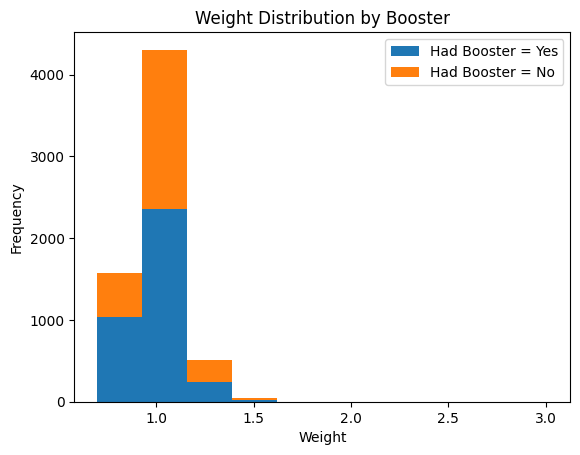

In [28]:
booster_weight_T = covid[covid['vac_boost_1'] == 1]["weight"]
booster_weight_F = covid[covid['vac_boost_1'] == 0]["weight"]

plt.hist([booster_weight_T, booster_weight_F], bins = 10, stacked = True)
plt.legend(['Had Booster = Yes', 'Had Booster = No'])
plt.title('Weight Distribution by Booster')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

Weight is heavily skewed to the right. Booster seesms to be evenly distributed across different weight. \\
Not a good attribute.

**Age(Numeric Variable) vs. Booster**

In [29]:
covid["age"].describe()

,age
count,6430.000000
mean,49.802488
std,18.069021
min,18.000000
25%,34.000000
50%,50.000000
75%,65.000000
max,90.000000


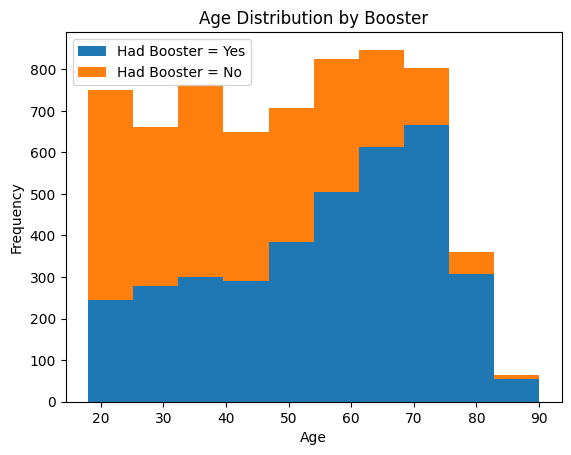

In [30]:
booster_weight_T = covid[covid['vac_boost_1'] == 1]["age"]
booster_weight_F = covid[covid['vac_boost_1'] == 0]["age"]

# create a stacked histogram of the two variables
plt.hist([booster_weight_T, booster_weight_F], bins = 10, stacked = True)
plt.legend(['Had Booster = Yes', 'Had Booster = No'])
plt.title('Age Distribution by Booster')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Pattern is not clear. Binning. \\
- Young Adults (18-29)

- Adults (30-49)

- Middle-Aged Adults (50-64)

- Older Adults (65-90)

In [31]:
covid['age binned'] = pd.cut(covid['age'], bins=[18, 30, 40, 65, 90],
                             labels=['young adults(18-29)', 'adults(30-49)',
                                     'middle-aged adults(50-64)', 'older adults(65-90)'],
                             right = False)

<ipython-input-23-aa9c63c895ec>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby([var, 'vac_boost_1']).size().unstack(fill_value=0)


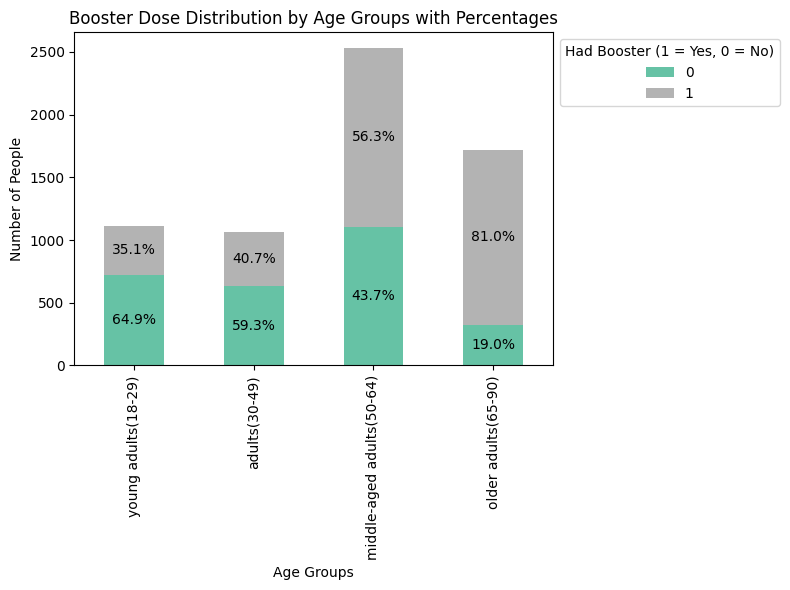

In [32]:
graph_with_boost('age binned', covid, 'Age Groups', 'Age Groups',(8, 6), 90)

In [33]:
crosstab_age = cross_tab('age binned','vac_boost_1', covid)

Result for age binned vs vac_boost_1:
Cramér's V: 0.3388393276555541
Chi-Square Statistic: 737.5528659420205
P-value: 1.509573914005464e-159


In [34]:
crosstab_age

vac_boost_1,0,1
age binned,,
young adults(18-29),722,390
adults(30-49),630,433
middle-aged adults(50-64),1106,1423
older adults(65-90),326,1394


As people grow oder, they tend to have booster.

**Employment status vs Booster**

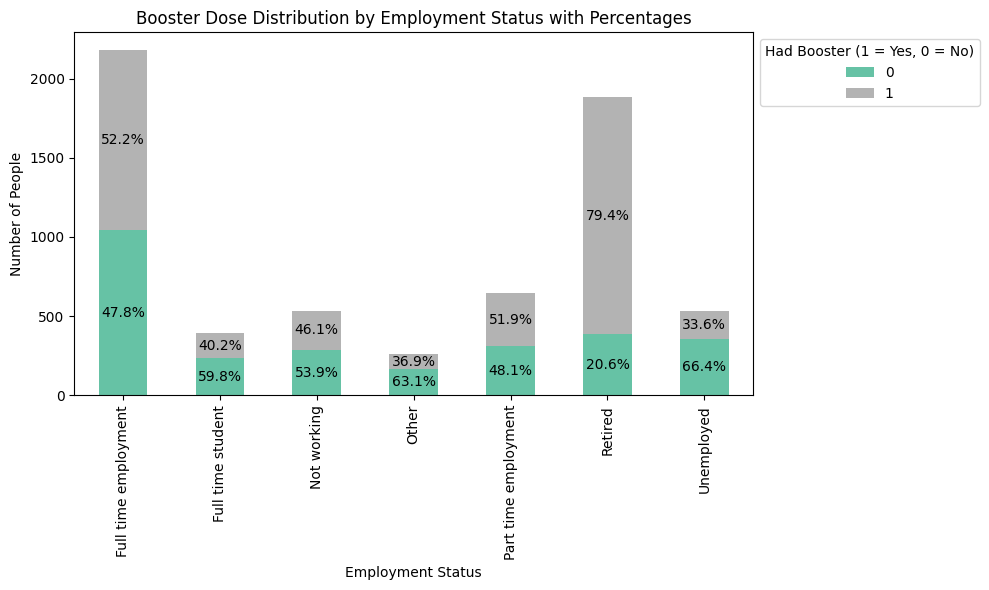

In [35]:
graph_with_boost('employment_status', covid, 'Employment Status', 'Employment Status', (10, 6), xtick=90)

Pattern is not clear. Reclassify the employment status. \\


In [36]:
# Reclassifying using map
employ_map = {'Full time employment': 'Full time', 'Full time student': 'Full time',
              'Not working': 'Stay at home',
              'Retired': 'Retired',
              'Unemployed': 'Stay at home',
              'Other': 'Other',
              'Part time employment': 'Part time'}

covid_copy = covid.copy()

covid_copy['employment_status'] = covid_copy['employment_status'].map(employ_map)

print(covid_copy['employment_status'].value_counts())

employment_status
Full time       2575
Retired         1882
Stay at home    1067
Part time        646
Other            260
Name: count, dtype: int64


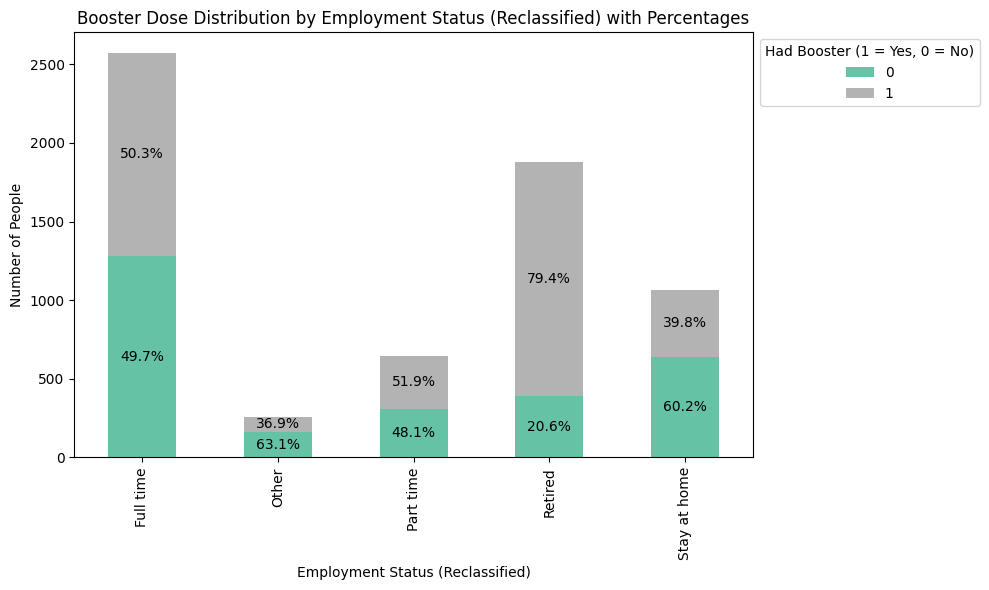

In [37]:
graph_with_boost('employment_status', covid_copy, 'Employment Status (Reclassified)',
                 'Employment Status (Reclassified)', (10, 6), xtick=90)

No interesting pattern. That Retired has large proportion of booster = 1 may be strongly correlated to age (Senior people tend to take booster).

**Region vs Booster**

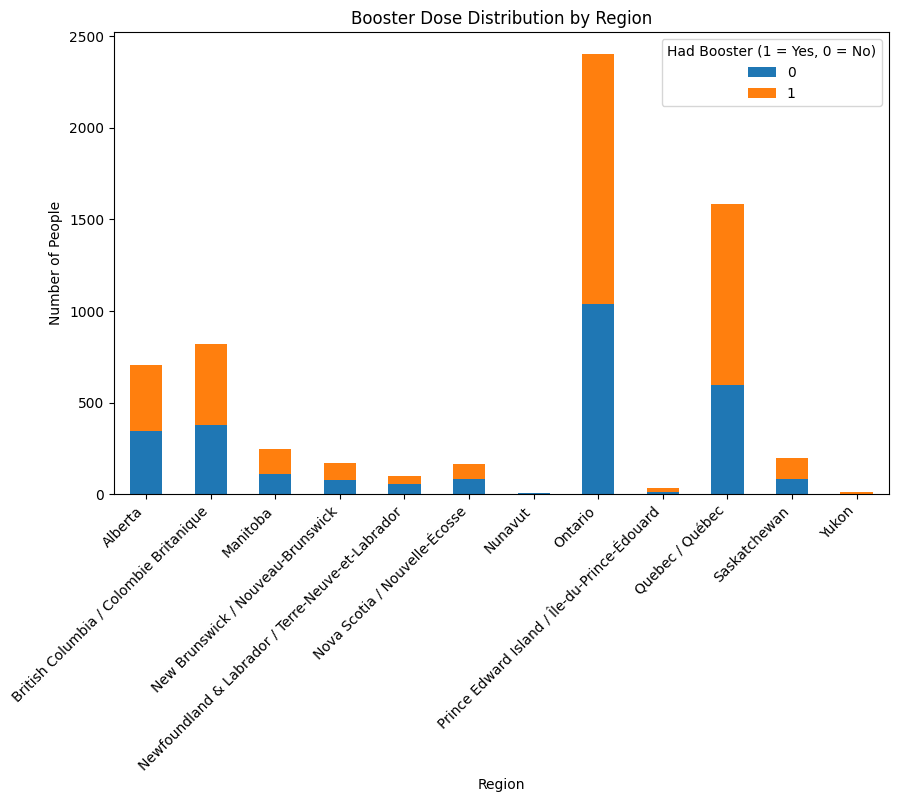

In [38]:
# Region vs Booster

# Group the data by 'region' and 'vac_boost_1', counting occurrences
grouped_data = covid.groupby(['region', 'vac_boost_1']).size().unstack(fill_value=0)

# Plot the stacked bar chart
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))


plt.title('Booster Dose Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of People')
plt.legend(title='Had Booster (1 = Yes, 0 = No)')
plt.xticks(rotation=45, ha='right')
plt.show()

No interesting patterns here.

**Gender vs Booster**

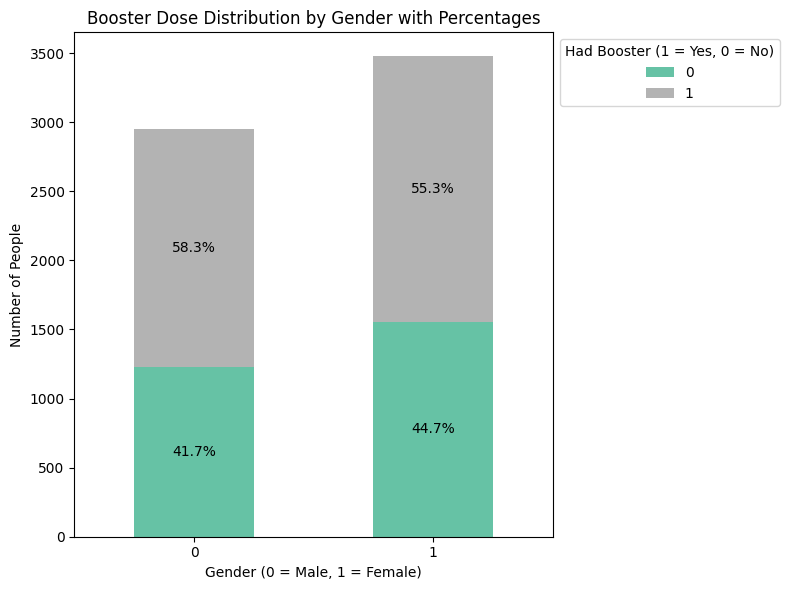

In [39]:
graph_with_boost('gender', covid, 'Gender',
                 'Gender (0 = Male, 1 = Female)', (8, 6), 0)

No significant differnece between Males and Females taking booster shots

**Household Size vs Booster**

Graph of household sizes vs whether an individual got booster shots

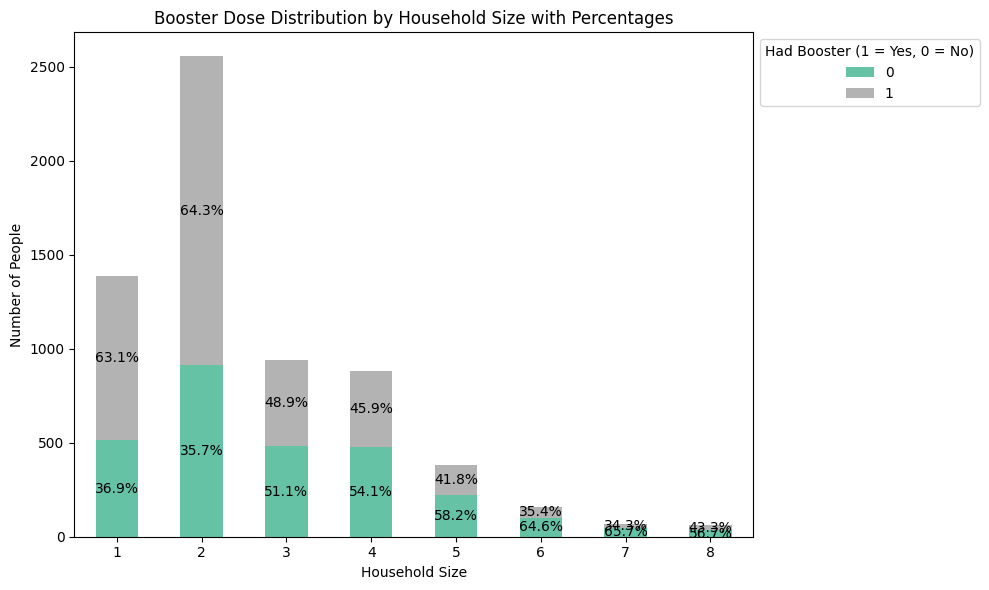

In [40]:
graph_with_boost('household_size', covid, 'Household Size', 'Household Size', (10, 6), 0)

As the household size increases, the percentage of people getting a booster declines.

#### ***2.2 Preventing Actions Against COVID-19***

**i9_health vs. Booster** \\
- i9_health: For the next 7 days…would you isolate yourself after feeling unwell or having any of the following new symptoms (a dry cough, fever, loss of sense of smell, loss of sense of taste, shortness of breath or difficulty breathing?)

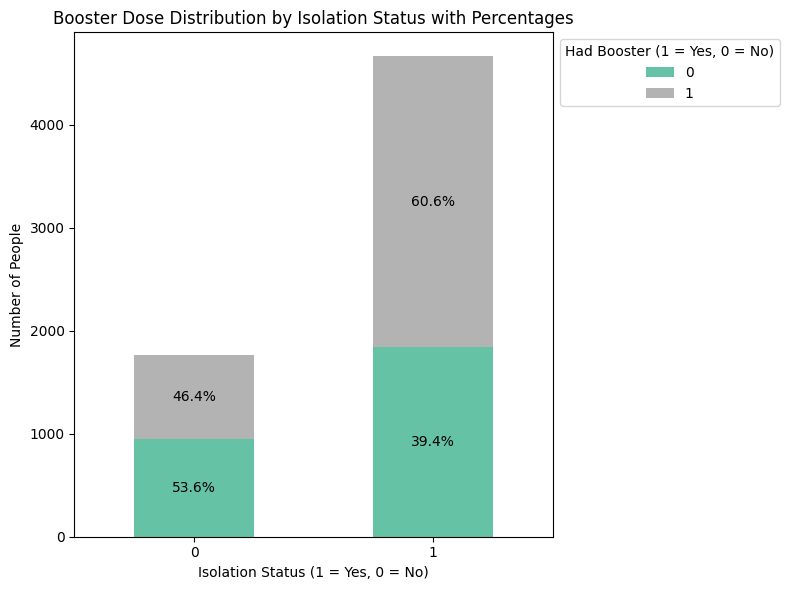

In [41]:
graph_with_boost('i9_health', covid, 'Isolation Status', 'Isolation Status (1 = Yes, 0 = No)', (8, 6), 0)

In [42]:
cross_tab_i9 = cross_tab('i9_health','vac_boost_1', covid)

Result for i9_health vs vac_boost_1:
Cramér's V: 0.12757130071382705
Chi-Square Statistic: 104.64462840420777
P-value: 1.4612813385856861e-24


In [43]:
cross_tab_i9

vac_boost_1,0,1
i9_health,,
0,947,820
1,1837,2826


People who have had boosters are more willing to isolate themselves.

**i9_health vs household_size**

In [44]:
cross_tab_household_i9 = cross_tab('i9_health','household_size', covid)

Result for i9_health vs household_size:
Cramér's V: 0.1077839220614049
Chi-Square Statistic: 74.69971388725781
P-value: 1.6502679166696537e-13


Week correlation. Keep both.

**i12_health vs. Booster** \\
1 = very willing, 3 = neither unwilling nor willing, 5 = very unwilling \\
Variables too messy. Group them together.


In [45]:
covid['Face_mask'] = ((covid['i12_health_1'].isin([1, 2])) |
                      (covid['i12_health_22'].isin([1, 2])) |
                       (covid['i12_health_23'].isin([1, 2]))|
                        (covid['i12_health_25'].isin([1, 2]))).astype(int)

covid['dangerous_contact'] = ((covid['i12_health_5'].isin([1, 2]))|
                              (covid['i12_health_6'].isin([1, 2]))|
                               (covid['i12_health_7'].isin([1, 2]))|
                                (covid['i12_health_8'].isin([1, 2]))|
                                (covid['i12_health_14'].isin([1, 2]))|
                                (covid['i12_health_15'].isin([1, 2]))|
                                (covid['i12_health_26'].isin([1, 2]))|
                                (covid['i12_health_16'].isin([1, 2]))).astype(int)

covid['contact'] = ((covid['i12_health_11'].isin([1, 2]))|
                    (covid['i12_health_12'].isin([1, 2]))|
                    (covid['i12_health_27'].isin([1, 2]))|
                    (covid['i12_health_28'].isin([1, 2]))|
                    (covid['i12_health_29'].isin([1, 2]))).astype(int)

covid['sanitation'] = ((covid['i12_health_2'].isin([1, 2]))|
                       (covid['i12_health_3'].isin([1, 2]))|
                       (covid['i12_health_4'].isin([1, 2]))).astype(int)

In [46]:
covid['Face_mask'].value_counts()

,count
Face_mask,
1,6211
0,219


In [47]:
covid['dangerous_contact'].value_counts()

,count
dangerous_contact,
1,6013
0,417


In [48]:
covid['contact'].value_counts()

,count
contact,
1,5698
0,732


In [49]:
covid['sanitation'].value_counts()

,count
sanitation,
1,6280
0,150


Most people in the dataset had awareness of face mask wearing and sanitation. Ignore these two variables. \\
Test dangerous_contact and contact. \\

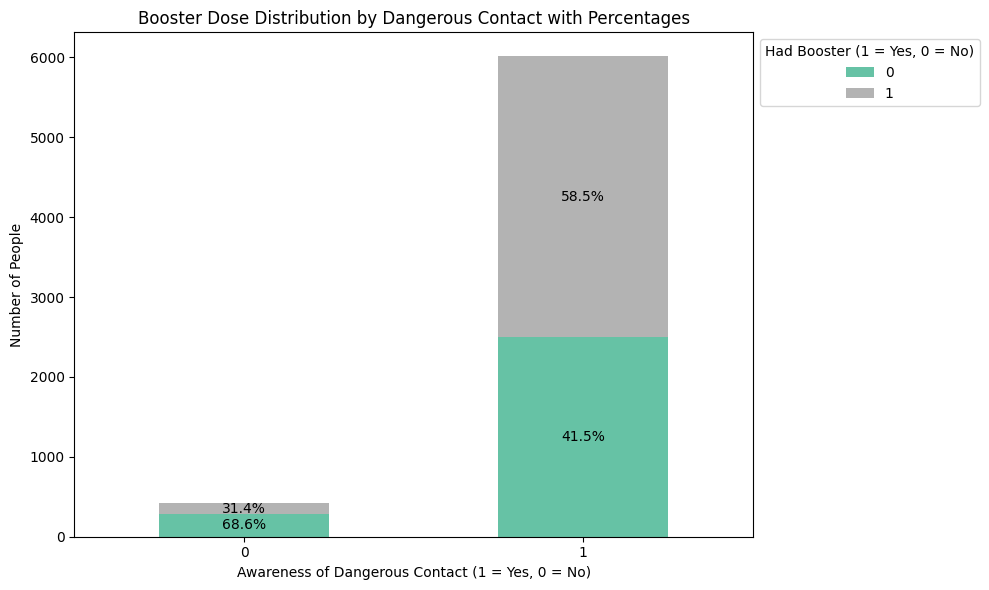

In [50]:
graph_with_boost('dangerous_contact', covid, 'Dangerous Contact', 'Awareness of Dangerous Contact (1 = Yes, 0 = No)', (10, 6), 0)

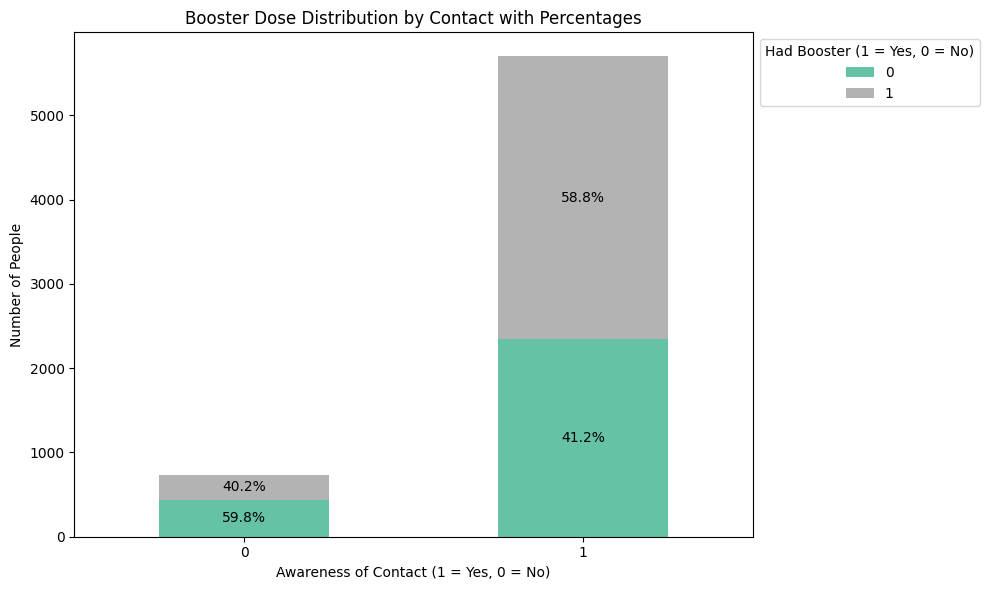

In [51]:
graph_with_boost('contact', covid, 'Contact', 'Awareness of Contact (1 = Yes, 0 = No)', (10, 6), 0)

In [52]:
cross_tab_dangerous = cross_tab('dangerous_contact','vac_boost_1', covid)

Result for dangerous_contact vs vac_boost_1:
Cramér's V: 0.13376494307067052
Chi-Square Statistic: 115.05237576591925
P-value: 7.664613452374265e-27


In [53]:
cross_tab_contact = cross_tab('contact','vac_boost_1', covid)

Result for contact vs vac_boost_1:
Cramér's V: 0.11914471469700237
Chi-Square Statistic: 91.2768273486795
P-value: 1.2491493189936675e-21


Both have patterns against booster. \\
See if they are correlated with other social distancing variables.

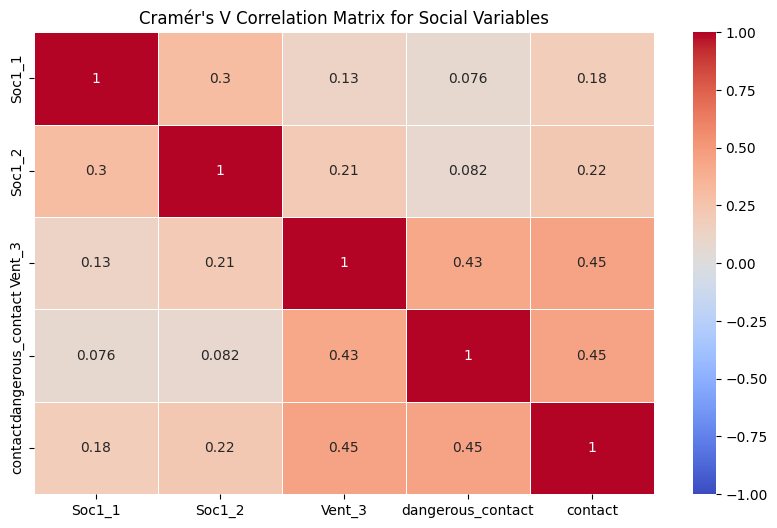

In [54]:
correlation_matrix(covid, ['Soc1_1', 'Soc1_2', 'Vent_3', 'dangerous_contact', 'contact'], 'Social Variables')

Keep dangerous contact instead of contact to avaoid correlation.

#### ***2.3 Emotion***

**Cantril Ladder vs Booster**

This is an emotion/happiness variable: the higher the value of cantril_ladder is the more happy the indiv is

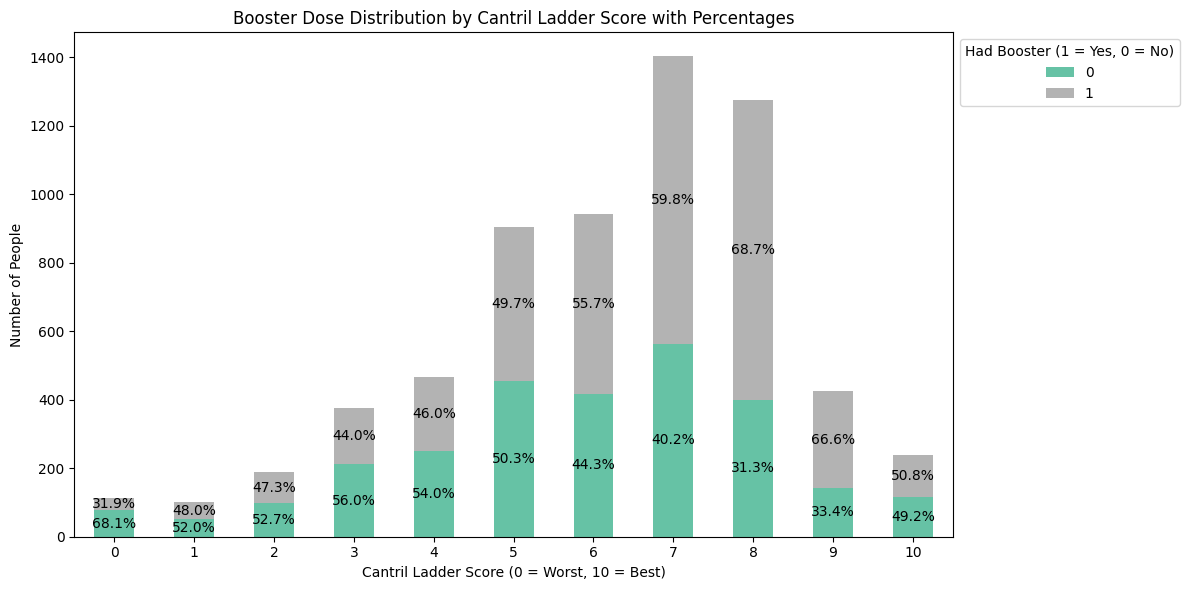

In [55]:
graph_with_boost('cantril_ladder', covid, 'Cantril Ladder Score',
                 'Cantril Ladder Score (0 = Worst, 10 = Best)', (12, 6), 0)

Higher Life Satisfaction (Scores 7-10) Corresponds with Higher Booster Uptake (except for lvl 10 wierdly enough). This pattern aligns with research suggesting that well-being and mental health are linked with better health practices.

**PHQ4 vs Booster**



*   PHQ4_1: Little interest or pleasure in doing things
*   PHQ4_2: Feeling down, depressed, or hopeless
*   PHQ4_3: Feeling nervous, anxious, or on edge
*   PHQ4_4: Not being able to stop or control worrying



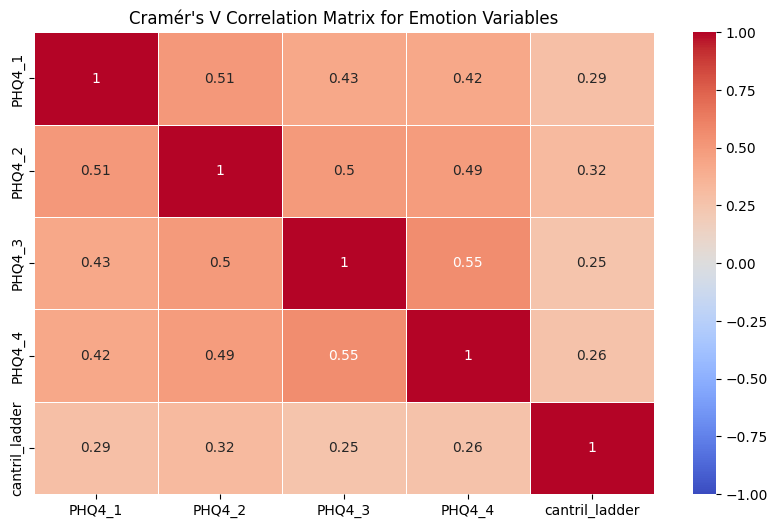

In [56]:
correlation_matrix(covid, ['PHQ4_1', 'PHQ4_2', 'PHQ4_3', 'PHQ4_4', 'cantril_ladder'], 'Emotion Variables')




*   The PHQ-4 variables are highly consistent, suggesting that the scale. effectively measures related aspects of psychological distress.
*   People with higher life satisfaction tend to report lower anxiety and depression symptoms, though the relationship is not very strong.



#### ***2.4 View towards government's measure***

**WCREX vs Booster**

WCREX1: How well or badly do you think the Government are handling the issue of the Coronavirus (COVID-19)?

WCREX2: And how much confidence do you have in the NHS to respond to a Coronavirus (COVID-19) outbreak in the UK?

lets first see at correlation between these two var

In [57]:
# Suppress floating-point warnings
np.seterr(all='ignore')

gov_nhs_data = covid[['WCRex1', 'WCRex2']].replace(5, np.nan).dropna()
correlation, p_value = pearsonr(gov_nhs_data['WCRex1'], gov_nhs_data['WCRex2'])
print(f"Correlation: {correlation}")

Correlation: 0.7487637504030858


People who have high confidence in the NHS are more likely to also have a positive perception of the government’s handling of the COVID-19 situation.

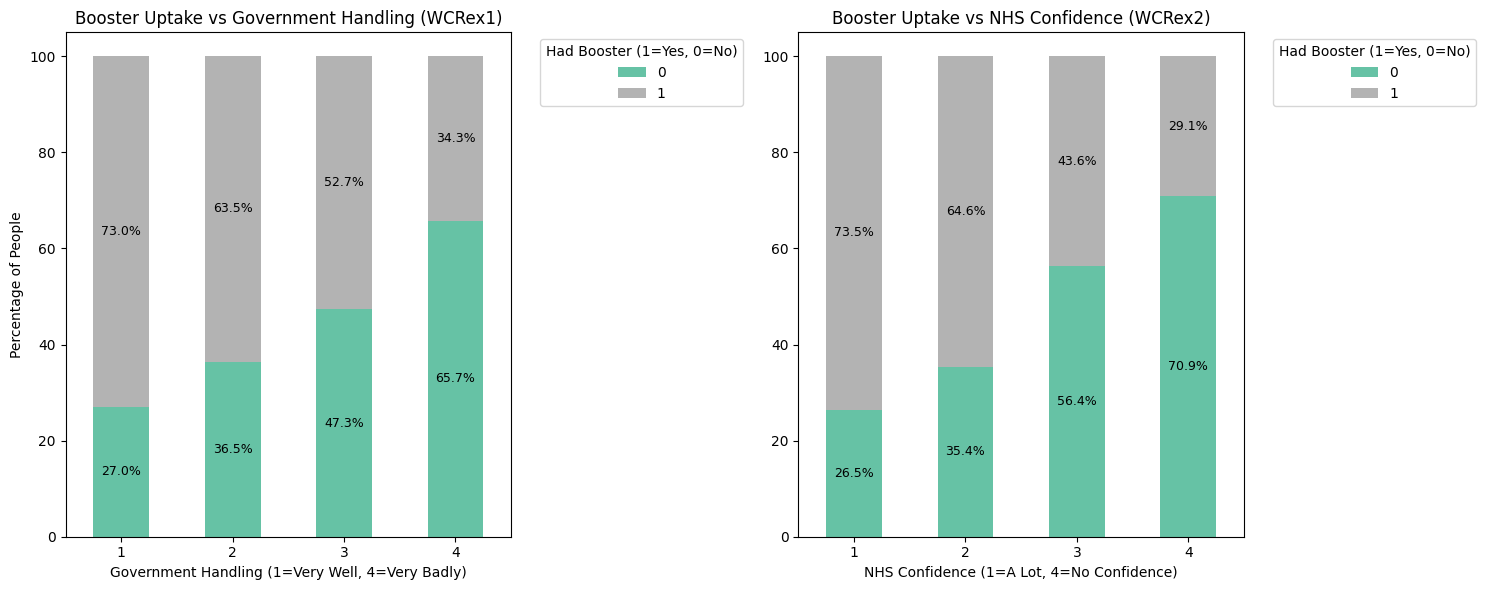

In [58]:
# Handle 'Don't know' responses and ensure valid levels (1-4)
booster_vs_gov_nhs = covid[['WCRex1', 'WCRex2', 'vac_boost_1']].replace(5, np.nan).dropna()


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for WCRex1 (Government Handling) vs Booster Uptake with Percentages
gov_booster = booster_vs_gov_nhs.groupby(['WCRex1', 'vac_boost_1']).size().unstack(fill_value=0)
gov_booster_percent = gov_booster.div(gov_booster.sum(axis=1), axis=0) * 100

gov_booster_percent.plot(kind='bar', stacked=True, ax=ax[0], colormap='Set2')
ax[0].set_title('Booster Uptake vs Government Handling (WCRex1)')
ax[0].set_xlabel('Government Handling (1=Very Well, 4=Very Badly)')
ax[0].set_ylabel('Percentage of People')
ax[0].legend(title='Had Booster (1=Yes, 0=No)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_xticklabels([1, 2, 3, 4], rotation=0)

for i, (index, row) in enumerate(gov_booster_percent.iterrows()):
    bottom = 0
    for j, value in enumerate(row):
        ax[0].text(i, bottom + value / 2, f'{value:.1f}%', ha='center', va='center', color='black', fontsize=9)
        bottom += value

# Plot for WCRex2 (NHS Confidence) vs Booster Uptake with Percentages
nhs_booster = booster_vs_gov_nhs.groupby(['WCRex2', 'vac_boost_1']).size().unstack(fill_value=0)
nhs_booster_percent = nhs_booster.div(nhs_booster.sum(axis=1), axis=0) * 100

nhs_booster_percent.plot(kind='bar', stacked=True, ax=ax[1], colormap='Set2')
ax[1].set_title('Booster Uptake vs NHS Confidence (WCRex2)')
ax[1].set_xlabel('NHS Confidence (1=A Lot, 4=No Confidence)')
ax[1].legend(title='Had Booster (1=Yes, 0=No)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].set_xticklabels([1, 2, 3, 4], rotation=0)

for i, (index, row) in enumerate(nhs_booster_percent.iterrows()):
    bottom = 0
    for j, value in enumerate(row):
        ax[1].text(i, bottom + value / 2, f'{value:.1f}%', ha='center', va='center', color='black', fontsize=9)
        bottom += value

plt.tight_layout()
plt.show()

Both plots demonstrate that public trust in government and the healthcare system plays a critical role in health-related behaviors like receiving COVID-19 boosters. If people trust institutions, they are more likely to follow vaccination guidance. Conversely, low trust leads to hesitancy, which has significant public health implications.

#### ***2.5 View towards coronavirus***

**R1 Variables vs Booster**

r1_1: Coronavirus (COVID-19) is very dangerous for me. nominal from 1 (disagree) to 7(agree)

r1_2: It is likely that I will get coronavirus (COVID-19) in the future. same sacle

r1_8: Getting a vaccine will protect me against coronavirus (COVID-19). same scale

r1_9: Getting a vaccine will protect others against coronavirus (COVID-19)

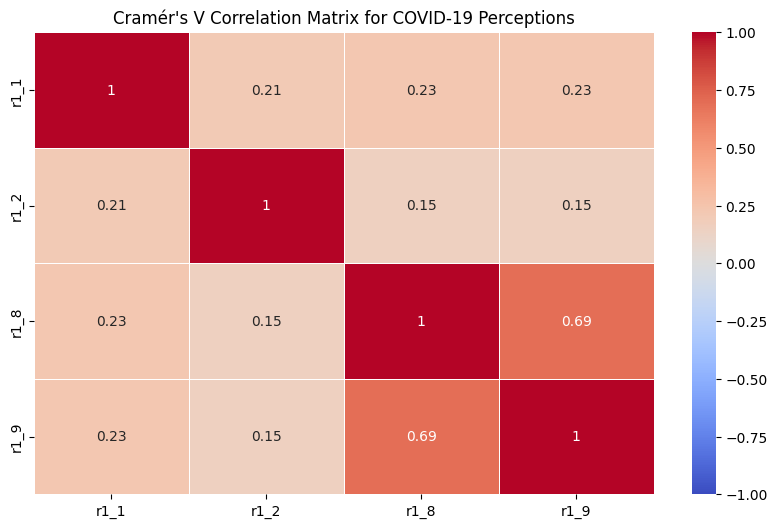

In [59]:
correlation_matrix(covid, ['r1_1', 'r1_2', 'r1_8', 'r1_9'], 'COVID-19 Perceptions')

There is a high alignment between personal and social vaccine benefits, indicating that people who value self-protection also value protecting other

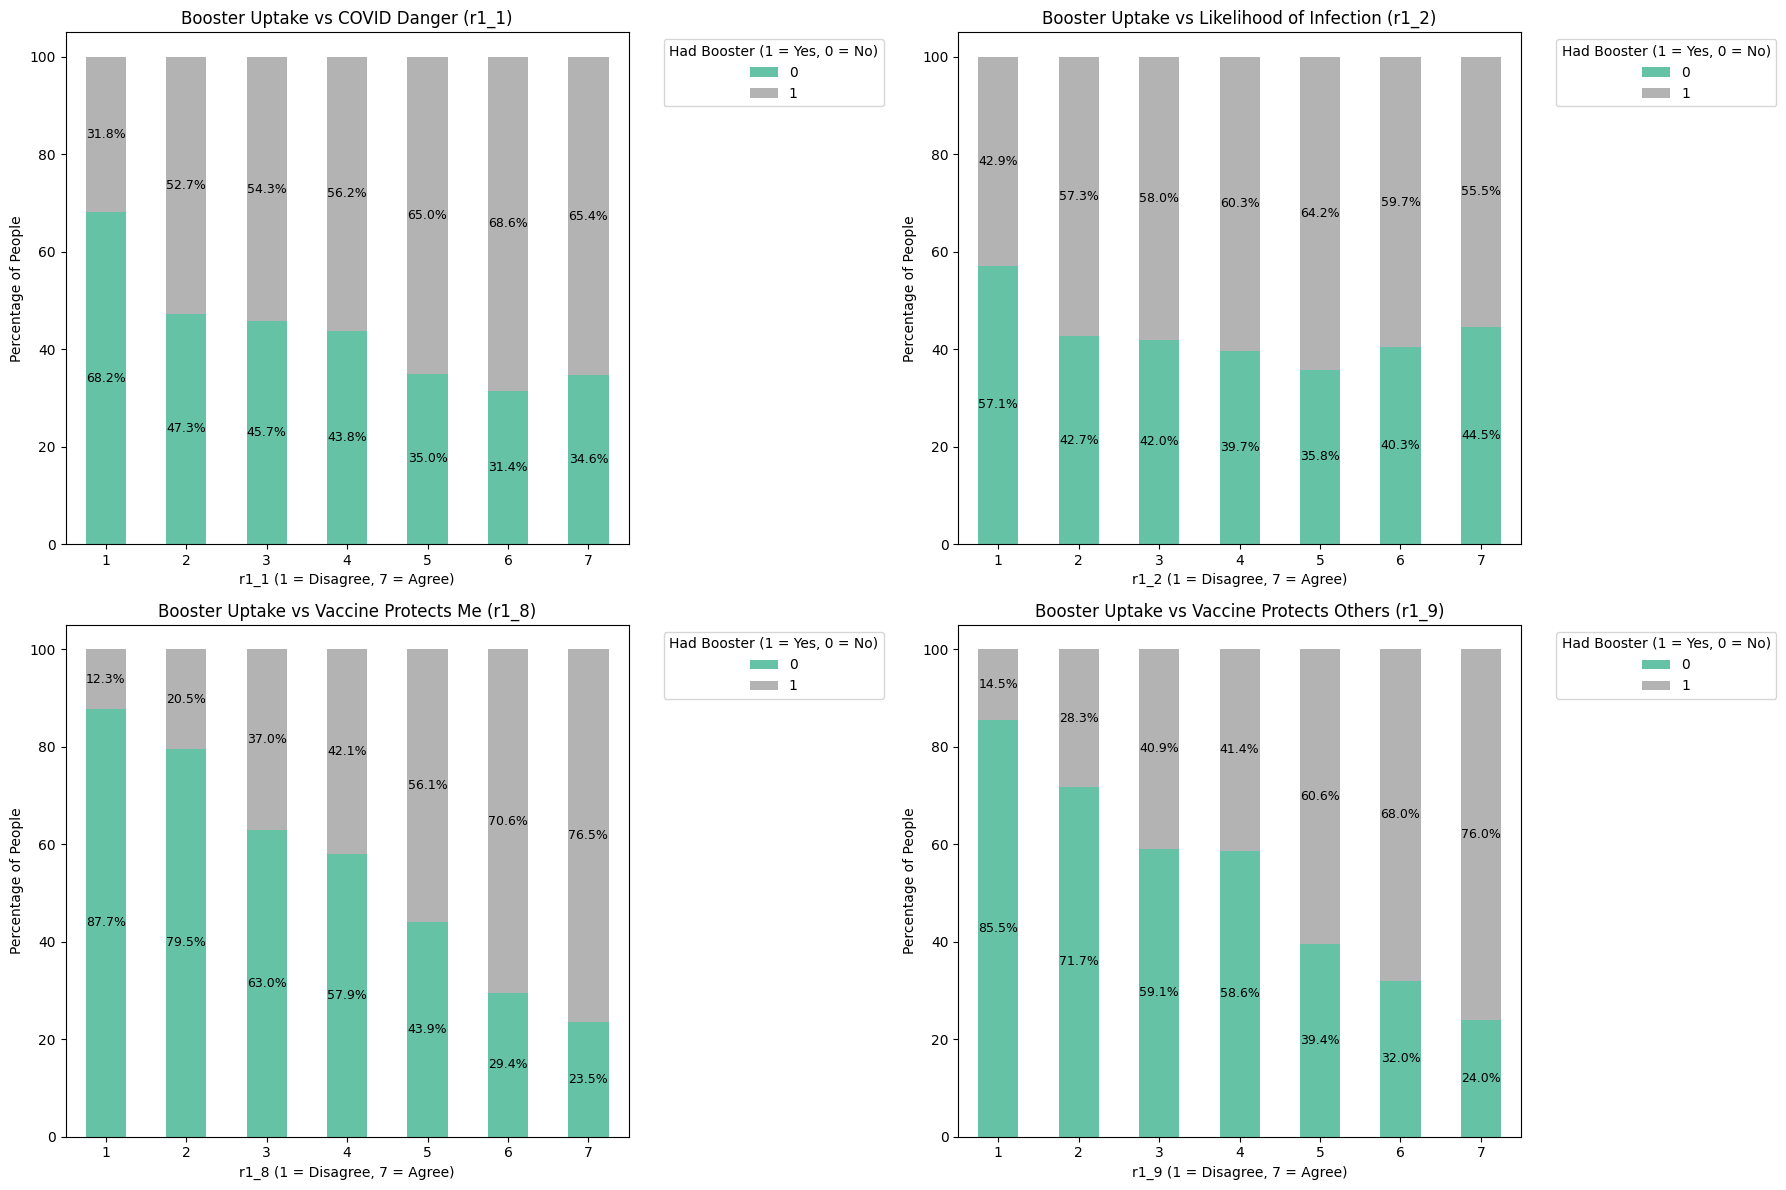

In [60]:
# Extract relevant data
booster_vs_perceptions = covid[['r1_1', 'r1_2', 'r1_8', 'r1_9', 'vac_boost_1']].dropna()

# Function to plot each variable against booster uptake
def plot_variable_against_booster(data, var, ax, title):
    grouped_data = data.groupby([var, 'vac_boost_1']).size().unstack(fill_value=0)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

    percentages.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')
    ax.set_title(title)
    ax.set_xlabel(f'{var} (1 = Disagree, 7 = Agree)')
    ax.set_ylabel('Percentage of People')
    ax.legend(title='Had Booster (1 = Yes, 0 = No)', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(grouped_data.index, rotation=0)

    for i, (index, row) in enumerate(percentages.iterrows()):
        bottom = 0
        for j, value in enumerate(row):
            ax.text(i, bottom + value / 2, f'{value:.1f}%', ha='center', va='center', fontsize=9)
            bottom += value


fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Plotting each variable against booster uptake
plot_variable_against_booster(booster_vs_perceptions, 'r1_1', ax[0, 0], 'Booster Uptake vs COVID Danger (r1_1)')
plot_variable_against_booster(booster_vs_perceptions, 'r1_2', ax[0, 1], 'Booster Uptake vs Likelihood of Infection (r1_2)')
plot_variable_against_booster(booster_vs_perceptions, 'r1_8', ax[1, 0], 'Booster Uptake vs Vaccine Protects Me (r1_8)')
plot_variable_against_booster(booster_vs_perceptions, 'r1_9', ax[1, 1], 'Booster Uptake vs Vaccine Protects Others (r1_9)')


plt.tight_layout()
plt.show()

Booster Uptake vs COVID-19 Danger Perception (r1_1):


*   Individuals who perceive COVID-19 as very dangerous are more likely to get a booster.

Booster Uptake vs Likelihood of Infection (r1_2):


*   The belief that one will get COVID-19 in the future has little to no influence on booster uptake.

Booster Uptake vs Vaccine Protects Me (r1_8):


*   People who strongly believe the vaccine protects them are much more likely to get a booster.


Booster Uptake vs Vaccine Protects Others (r1_9):


*    The belief that the vaccine protects others also has a strong positive impact on booster uptake,

#### ***2.6 Social Distancing***

**Soc1_1, Soc1_2, Soc1_3** \\
- Soc1_1: In an outdoor place in a group of 6 or more people
- Soc1_2: In an indoor place in a group of 6 or more people
- Soc1_3: Neither


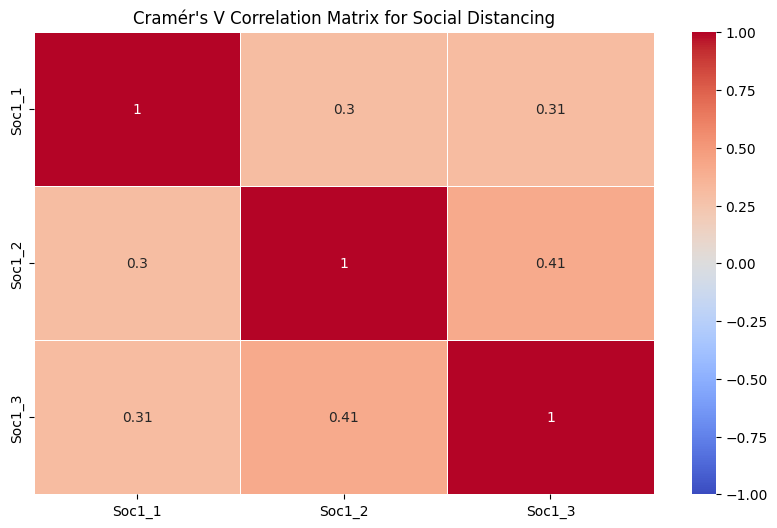

In [61]:
correlation_matrix(covid, ['Soc1_1', 'Soc1_2', 'Soc1_3'], 'Social Distancing')

No strong correlations. \\

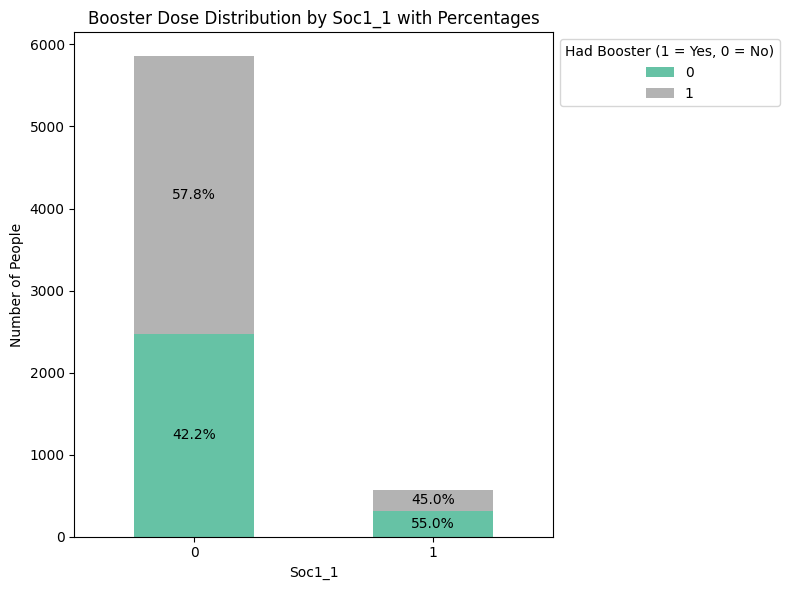

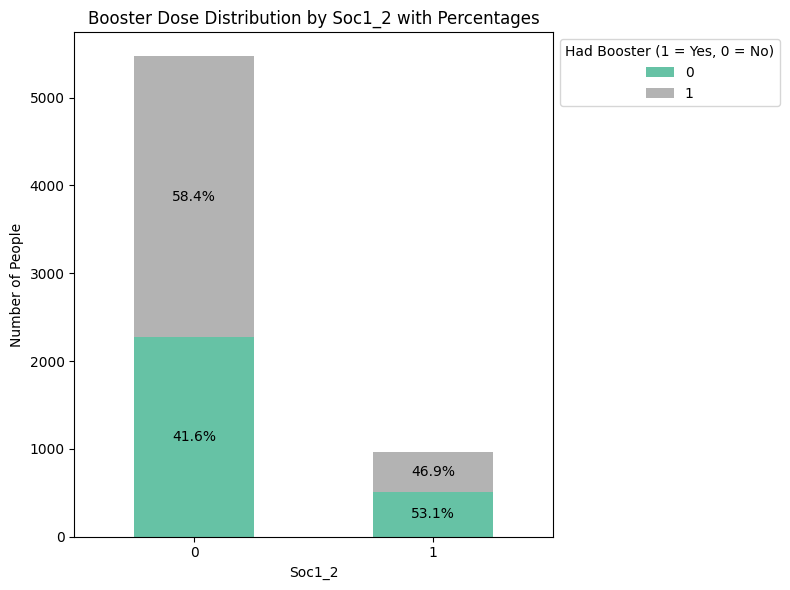

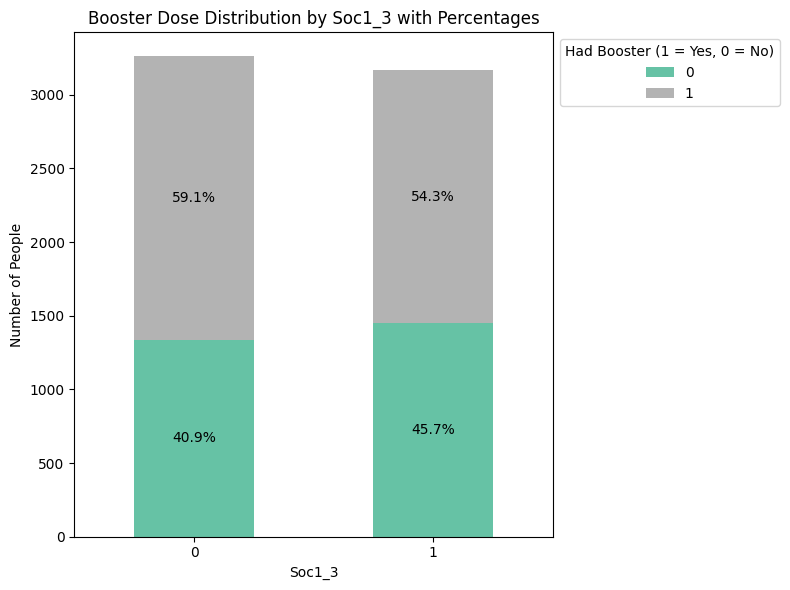

In [62]:
for var in ['Soc1_1', 'Soc1_2', 'Soc1_3']:
  graph_with_boost(var, covid, var, var, (8, 6), 0)

- **Soc1_2 vs Booster**: People who do not social with people indoor are more likely to have booster.

- **Soc1_1 vs Booster**: People who do not social with people outdoor are more likely to have booster.

- **Soc1_3 vs Booster**: No interesting pattern.

**Vent_3 vs Booster**

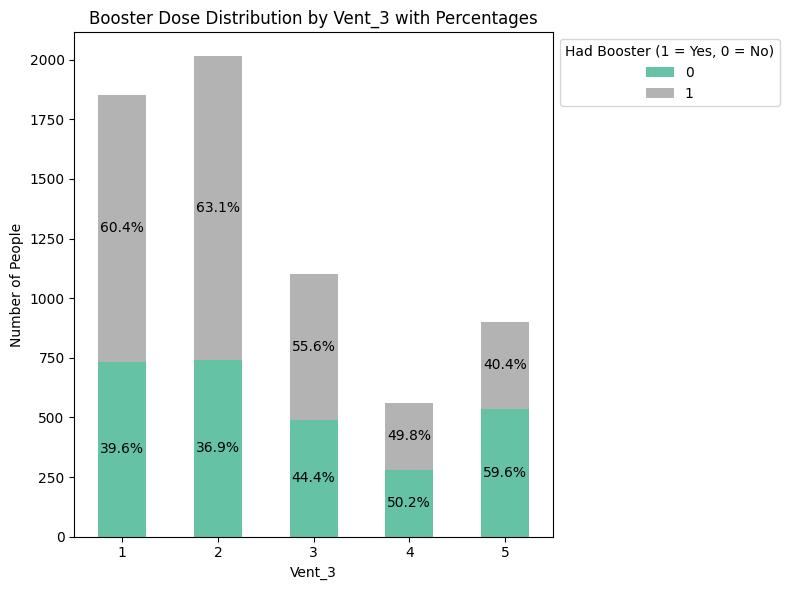

In [63]:
graph_with_boost('Vent_3', covid, 'Vent_3', 'Vent_3', (8, 6), 0)

In [64]:
cross_tab_vent = cross_tab('Vent_3','vac_boost_1', covid)

Result for Vent_3 vs vac_boost_1:
Cramér's V: 0.15384422760120103
Chi-Square Statistic: 152.18553813473125
P-value: 6.923790627536518e-32


People who frequently avoid social gathering tend to take booster.

#### ***2.7 Vaccine***

**vac2_2 vs Booster** \\
worried about potential side effects of a COVID19 vaccine. \\
1: Strongly agree, 5: Strongly disagree

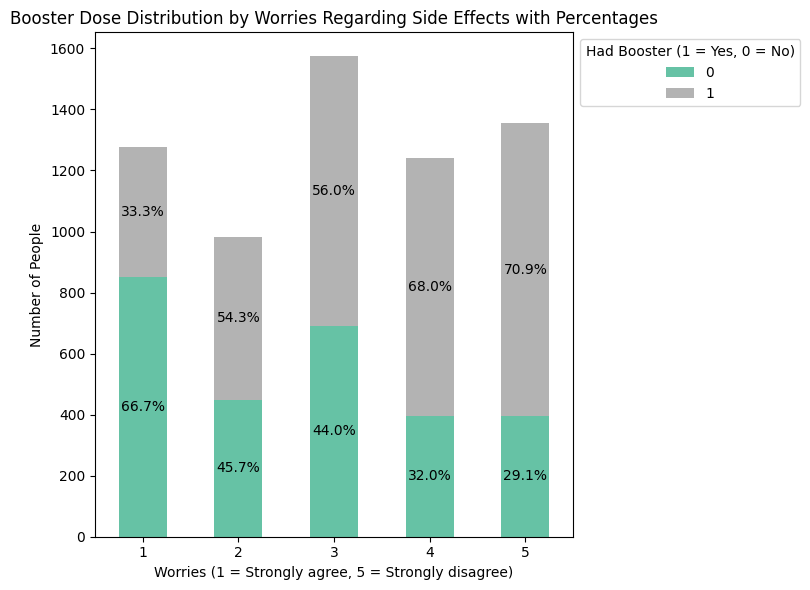

In [65]:
graph_with_boost('vac2_2', covid, 'Worries Regarding Side Effects', 'Worries (1 = Strongly agree, 5 = Strongly disagree)', (8, 6), 0)

In [66]:
cross_tab_vent = cross_tab('vac2_2','vac_boost_1', covid)

Result for vac2_2 vs vac_boost_1:
Cramér's V: 0.2682001130366734
Chi-Square Statistic: 462.51826306944673
P-value: 8.53902101773224e-99


People who have less worries regarding side effect of vaccines tend to have booster.

**vac7 vs Booster** \\
How much do you trust COVID-19 vaccines? \\
1 = not at all, 4 = very much

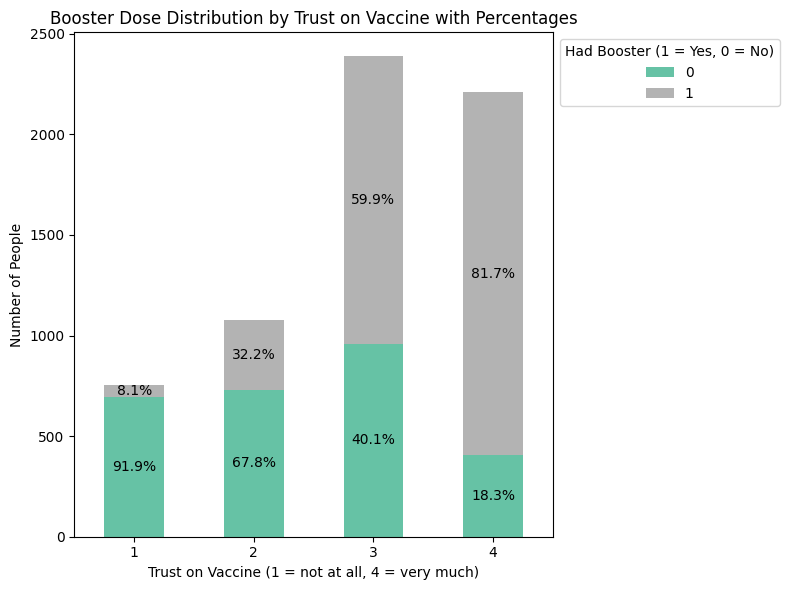

In [67]:
graph_with_boost('vac7', covid, 'Trust on Vaccine', 'Trust on Vaccine (1 = not at all, 4 = very much)', (8, 6), 0)

In [68]:
cross_tab_vac7 = cross_tab('vac7','vac_boost_1', covid)

Result for vac7 vs vac_boost_1:
Cramér's V: 0.4931964977483654
Chi-Square Statistic: 1564.0511100657593
P-value: 0.0


People who trust vaccines tend to take booster.

**vac2_2 vs vac7** \\
These two variables are similar $→$ check correlation

In [69]:
cross_tab_vac = cross_tab('vac7','vac2_2', covid)

Result for vac7 vs vac2_2:
Cramér's V: 0.3473053622110588
Chi-Square Statistic: 2326.779372030501
P-value: 0.0


Correlation is not that strong. Keep both variables.

**vac vs booster**

vac: 2 = two does, 1 = one does, 0 = neither \\
vac and booster would have strong correlation, since people take at least 1 does before taking booster.

In [70]:
cross_tab_vac = cross_tab('vac','vac_boost_1', covid)

Result for vac vs vac_boost_1:
Cramér's V: 0.407179840564785
Chi-Square Statistic: 1066.0645670759989
P-value: 3.2138128519915436e-232


**vac_man_1 vs Booster** \\
We believe healthcare people should get boosters but if people disagree that means they think vacc is useless. \\

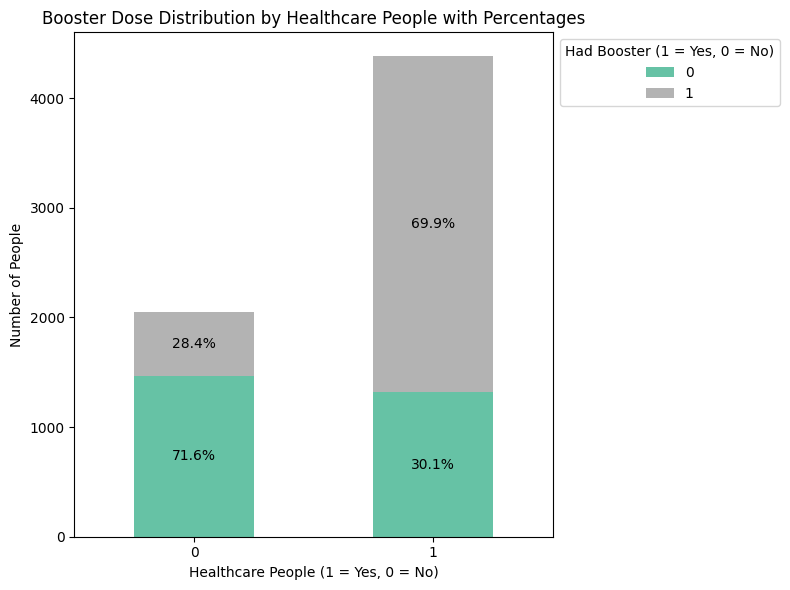

In [71]:
graph_with_boost('vac_man_1', covid, 'Healthcare People', 'Healthcare People (1 = Yes, 0 = No)', (8, 6), 0)

In [72]:
cross_tab_man1 = cross_tab('vac_man_1','vac_boost_1', covid)

Result for vac_man_1 vs vac_boost_1:
Cramér's V: 0.39059572251647967
Chi-Square Statistic: 980.9930686217381
P-value: 2.430677057182218e-215


People who believe healthcare people should take booster tend to take booster. This may be due to their trust on effectiveness of booster.

**vac_man_3 vs Booster** \\
We believe frontline emergency people should get boosters but if people disagree that means they think vacc is useless. \\

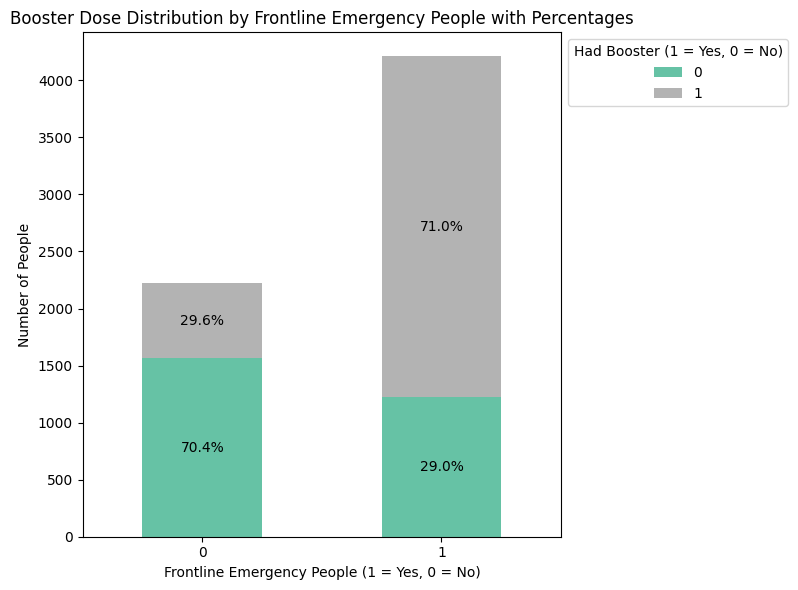

In [73]:
graph_with_boost('vac_man_3', covid, 'Frontline Emergency People', 'Frontline Emergency People (1 = Yes, 0 = No)', (8, 6), 0)

In [74]:
cross_tab_man3 = cross_tab('vac_man_3','vac_boost_1', covid)

Result for vac_man_3 vs vac_boost_1:
Cramér's V: 0.3962989156098771
Chi-Square Statistic: 1009.84970020222
P-value: 1.298095120035663e-221


People who believe frontline emergency people should take booster tend to take booster. This may be due to their trust on effectiveness of booster.

**vac_man_1 vs vac_man_3**

In [75]:
cross_tab_man = cross_tab('vac_man_1','vac_man_3', covid)

Result for vac_man_1 vs vac_man_3:
Cramér's V: 0.8821149900408403
Chi-Square Statistic: 5003.355681860054
P-value: 0.0


Strong correlation. Keep one. \\
vac_man_3 has stronger correlation with boost. \\
 Keep vac_man_3

### **Select Variables after EDA**



In [76]:
# parsa decision
personal_info = ['age','household_size']
emotion = ['cantril_ladder', 'PHQ4_3']
government = ['WCRex1']
coronavirus = ['r1_1', 'r1_2', 'r1_9']


# jessie
isolation = ['i9_health', 'dangerous_contact']
social_distancing = ['Soc1_1', 'Soc1_2', 'Vent_3']
vaccine = ['vac2_2', 'vac7', 'vac_man_3']

# target
target = ['vac_boost_1']


variables_selected = personal_info + emotion + government + coronavirus + isolation + social_distancing + vaccine + target

In [77]:
final_covid = covid[variables_selected]

# **Step3: Model Training**

***Notes from EDA:*** \\
Variable required to be changed into dummies: household_size \\
Categorical variables with internal orders are not changed to dummies


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [79]:
final_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                6430 non-null   int64
 1   household_size     6430 non-null   int64
 2   cantril_ladder     6430 non-null   int64
 3   PHQ4_3             6430 non-null   int64
 4   WCRex1             6430 non-null   int64
 5   r1_1               6430 non-null   int64
 6   r1_2               6430 non-null   int64
 7   r1_9               6430 non-null   int64
 8   i9_health          6430 non-null   int64
 9   dangerous_contact  6430 non-null   int64
 10  Soc1_1             6430 non-null   int64
 11  Soc1_2             6430 non-null   int64
 12  Vent_3             6430 non-null   int64
 13  vac2_2             6430 non-null   int64
 14  vac7               6430 non-null   int64
 15  vac_man_3          6430 non-null   int64
 16  vac_boost_1        6430 non-null   int64
dtypes: int64(17)
m

In [80]:
final_covid.shape

(6430, 17)

**get dummies for household_size**

In [81]:
final_covid = pd.get_dummies(final_covid, columns = ['household_size'], drop_first=True)
final_covid.shape

(6430, 23)

In [82]:
X = final_covid.loc[:, final_covid.columns != "vac_boost_1"]

In [83]:
y = covid.loc[:,["vac_boost_1"]]
y = y.values.ravel()

In [84]:
test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [85]:
model = KNeighborsClassifier()
num_folds = 10
scoring = 'accuracy'

In [86]:
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
kfold.get_n_splits(X_train)

10

In [87]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

In [88]:
msg = "KNN: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

KNN: 0.744939 (0.019091)


In [89]:
cv_results

array([0.76116505, 0.74563107, 0.73592233, 0.76893204, 0.73735409,
       0.74708171, 0.77042802, 0.74902724, 0.73151751, 0.70233463])

#### Fit a model with scaling the X variable values

In [90]:
scaler = StandardScaler().fit(X_train)
rescaledX_train = scaler.transform(X_train)
k_values = np.arange(1,30)
param_grid = dict(n_neighbors=k_values)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX_train, y_train)

In [91]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.743389 using {'n_neighbors': 22}


In [92]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [93]:
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

0.694782 (0.016663) with: {'n_neighbors': 1}
0.681376 (0.021765) with: {'n_neighbors': 2}
0.729199 (0.015476) with: {'n_neighbors': 3}
0.712868 (0.013938) with: {'n_neighbors': 4}
0.733282 (0.017112) with: {'n_neighbors': 5}
0.729005 (0.015102) with: {'n_neighbors': 6}
0.729203 (0.015562) with: {'n_neighbors': 7}
0.733866 (0.015119) with: {'n_neighbors': 8}
0.740083 (0.017160) with: {'n_neighbors': 9}
0.737948 (0.012213) with: {'n_neighbors': 10}
0.734063 (0.014626) with: {'n_neighbors': 11}
0.742615 (0.015729) with: {'n_neighbors': 12}
0.738727 (0.014109) with: {'n_neighbors': 13}
0.739309 (0.013726) with: {'n_neighbors': 14}
0.741059 (0.011323) with: {'n_neighbors': 15}
0.740281 (0.010360) with: {'n_neighbors': 16}
0.736975 (0.010817) with: {'n_neighbors': 17}
0.742226 (0.010349) with: {'n_neighbors': 18}
0.742225 (0.009856) with: {'n_neighbors': 19}
0.742223 (0.010553) with: {'n_neighbors': 20}
0.742225 (0.010911) with: {'n_neighbors': 21}
0.743389 (0.007631) with: {'n_neighbors': 2

Text(0, 0.5, 'Accuracy Score')

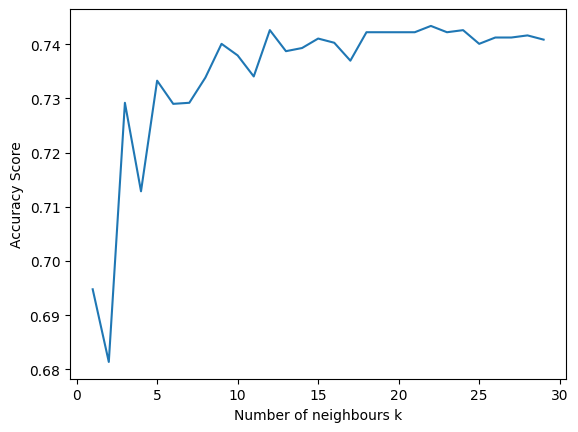

In [94]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbours k")
plt.ylabel("Accuracy Score")

In [95]:
model1 = KNeighborsClassifier(n_neighbors=22)
model1.fit(rescaledX_train, y_train)

KNeighborsClassifier(n_neighbors=22)

In [96]:
rescaledX_test = scaler.transform(X_test)
estimates_1 = model1.predict(rescaledX_test)
estimates_1

array([0, 1, 0, ..., 1, 1, 1])

In [97]:
print(y_test)

[0 1 0 ... 1 1 1]


In [98]:
accuracy_score(y_test, estimates_1)

0.7433903576982893

In [99]:
model1.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 22,
 'p': 2,
 'weights': 'uniform'}

#### Fit a model without scaling the X variable values

In [100]:
k_values = np.arange(1,30)
param_grid = dict(n_neighbors=k_values)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result2 = grid.fit(X_train, y_train)

In [101]:
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))

Best: 0.746496 using {'n_neighbors': 7}


In [102]:
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']

In [103]:
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

0.717916 (0.023615) with: {'n_neighbors': 1}
0.702174 (0.017740) with: {'n_neighbors': 2}
0.742217 (0.019312) with: {'n_neighbors': 3}
0.733664 (0.017178) with: {'n_neighbors': 4}
0.744939 (0.019091) with: {'n_neighbors': 5}
0.743384 (0.017831) with: {'n_neighbors': 6}
0.746496 (0.021572) with: {'n_neighbors': 7}
0.739109 (0.020832) with: {'n_neighbors': 8}
0.739689 (0.023059) with: {'n_neighbors': 9}
0.742021 (0.019821) with: {'n_neighbors': 10}
0.740664 (0.015646) with: {'n_neighbors': 11}
0.738139 (0.015702) with: {'n_neighbors': 12}
0.738720 (0.017621) with: {'n_neighbors': 13}
0.737164 (0.014137) with: {'n_neighbors': 14}
0.740470 (0.014158) with: {'n_neighbors': 15}
0.740862 (0.017181) with: {'n_neighbors': 16}
0.741833 (0.018028) with: {'n_neighbors': 17}
0.740085 (0.015319) with: {'n_neighbors': 18}
0.745528 (0.014908) with: {'n_neighbors': 19}
0.743001 (0.015053) with: {'n_neighbors': 20}
0.745917 (0.014920) with: {'n_neighbors': 21}
0.745722 (0.015556) with: {'n_neighbors': 2

Text(0, 0.5, 'Accuracy Score')

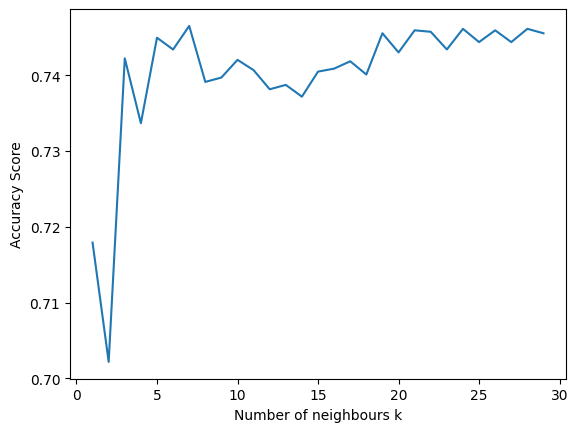

In [104]:
plt.plot(k_values, means)
plt.xlabel("Number of neighbours k")
plt.ylabel("Accuracy Score")

In [105]:
model2 = KNeighborsClassifier(n_neighbors=7)
model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [106]:
estimates_2 = model2.predict(X_test)
estimates_2

array([0, 1, 0, ..., 1, 1, 1])

In [107]:
print(y_test)

[0 1 0 ... 1 1 1]


In [108]:
accuracy_score(y_test, estimates_2)

0.7356143079315708

In [109]:
model2.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

# **Step4: Model Testing**

**Comment on which model will be used eventually in this step.**

In [110]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

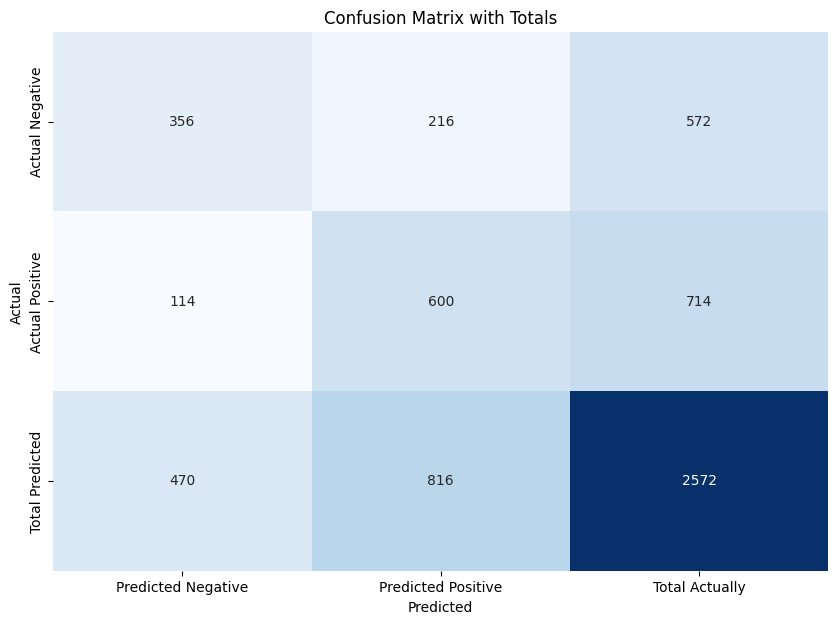

In [111]:
conf_matrix = confusion_matrix(y_test, estimates_1)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
conf_matrix_df['Total Actually'] = conf_matrix_df.sum(axis=1)
total_row = pd.DataFrame(conf_matrix_df.sum(axis=0)).transpose()
total_row.index = ['Total Predicted']
conf_matrix_df = pd.concat([conf_matrix_df, total_row])
conf_matrix_df.loc['Total Predicted', 'Total Actually'] = conf_matrix_df.loc['Total Predicted'].sum()

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix with Totals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

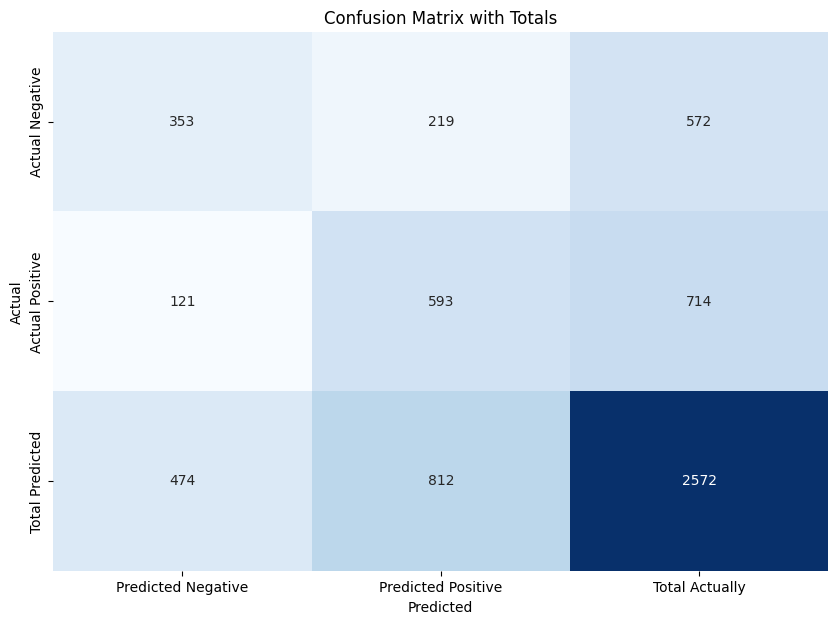

In [112]:
conf_matrix = confusion_matrix(y_test, estimates_2)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
conf_matrix_df['Total Actually'] = conf_matrix_df.sum(axis=1)
total_row = pd.DataFrame(conf_matrix_df.sum(axis=0)).transpose()
total_row.index = ['Total Predicted']
conf_matrix_df = pd.concat([conf_matrix_df, total_row])
conf_matrix_df.loc['Total Predicted', 'Total Actually'] = conf_matrix_df.loc['Total Predicted'].sum()
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix with Totals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [113]:
tn, fp, fn, tp = confusion_matrix(y_test, estimates_1).ravel()

# Accuracy and Overall Error Rate
accuracy = (tp + tn) / (tp + tn + fp + fn)
overall_error_rate = 1 - accuracy

# Sensitivity (Recall) and Specificity
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate

# False Positive Rate and False Negative Rate
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Proportions of True Positives, True Negatives, False Positives, and False Negatives
proportion_tp = tp / (tp + fp + fn + tn)
proportion_tn = tn / (tp + fp + fn + tn)
proportion_fp = fp / (tp + fp + fn + tn)
proportion_fn = fn / (tp + fp + fn + tn)


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Error Rate: {overall_error_rate * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"False Positive Rate: {false_positive_rate * 100:.2f}%")
print(f"False Negative Rate: {false_negative_rate * 100:.2f}%")
print(f"Proportion of True Positives: {proportion_tp * 100:.2f}%")
print(f"Proportion of True Negatives: {proportion_tn * 100:.2f}%")
print(f"Proportion of False Positives: {proportion_fp * 100:.2f}%")
print(f"Proportion of False Negatives: {proportion_fn * 100:.2f}%")

Accuracy: 74.34%
Overall Error Rate: 25.66%
Sensitivity (Recall): 84.03%
Specificity: 62.24%
False Positive Rate: 37.76%
False Negative Rate: 15.97%
Proportion of True Positives: 46.66%
Proportion of True Negatives: 27.68%
Proportion of False Positives: 16.80%
Proportion of False Negatives: 8.86%


In [114]:
tn, fp, fn, tp = confusion_matrix(y_test, estimates_2).ravel()

# Accuracy and Overall Error Rate
accuracy = (tp + tn) / (tp + tn + fp + fn)
overall_error_rate = 1 - accuracy

# Sensitivity (Recall) and Specificity
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate

# False Positive Rate and False Negative Rate
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Proportions of True Positives, True Negatives, False Positives, and False Negatives
proportion_tp = tp / (tp + fp + fn + tn)
proportion_tn = tn / (tp + fp + fn + tn)
proportion_fp = fp / (tp + fp + fn + tn)
proportion_fn = fn / (tp + fp + fn + tn)


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Error Rate: {overall_error_rate * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"False Positive Rate: {false_positive_rate * 100:.2f}%")
print(f"False Negative Rate: {false_negative_rate * 100:.2f}%")
print(f"Proportion of True Positives: {proportion_tp * 100:.2f}%")
print(f"Proportion of True Negatives: {proportion_tn * 100:.2f}%")
print(f"Proportion of False Positives: {proportion_fp * 100:.2f}%")
print(f"Proportion of False Negatives: {proportion_fn * 100:.2f}%")

Accuracy: 73.56%
Overall Error Rate: 26.44%
Sensitivity (Recall): 83.05%
Specificity: 61.71%
False Positive Rate: 38.29%
False Negative Rate: 16.95%
Proportion of True Positives: 46.11%
Proportion of True Negatives: 27.45%
Proportion of False Positives: 17.03%
Proportion of False Negatives: 9.41%
